In [14]:
llema_file_path = "inference_competition_math_results/llemma_competition_math_extracted_answers_2.txt"

mistral_file_path = "inference_competition_math_results/Mistral_Inference_Competition_Dataset.csv"

llama_file_path = "inference_competition_math_results/inference_llama3_competition_math.csv"

qwen_file_path = "inference_competition_math_results/inference_QWEN_competition_math.csv"

In [41]:
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
import matplotlib.pyplot as plt
import numpy as np

competition_math_dict = load_dataset("jeggers/competition_math", "original")
test_dataset = competition_math_dict["test"]
test_dataset_df = pd.DataFrame(test_dataset)
test_dataset_df["row_index"] = test_dataset_df.index

def format_llema_inference_competition_math():
    with open(llema_file_path, "r") as file:
        data = [eval(line.strip()) for line in file]
    df = pd.DataFrame(data)
    llema_test_dataset= df.merge(test_dataset_df, left_on='Iteration', right_on='row_index')
    llema_test_dataset["level:type"] = llema_test_dataset["level"] + ": " + llema_test_dataset["type"]

    llema_test_dataset["llema_is_correct"] =  (llema_test_dataset["Final Solution"] == llema_test_dataset["extracted_solution"])

    llema_test_dataset = llema_test_dataset.rename(columns={"Final Solution": "llema_solution"})

    llema_3_results = llema_test_dataset[["row_index", "level", "type", "llema_is_correct", "llema_solution"]]
    return llema_3_results

def format_mistral_inference_competition_math():
    df = pd.read_csv(mistral_file_path)
    mistral_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    mistral_test_dataset["mistral_is_correct"] = (mistral_test_dataset["Run_1"] == mistral_test_dataset["extracted_solution"])
    mistral_test_dataset["level:type"] = mistral_test_dataset["level"] + ": " + mistral_test_dataset["type"]

    mistral_test_dataset = mistral_test_dataset.rename(columns={"Run_1": "mistral_solution"})

    mistral_results = mistral_test_dataset[["row_index", "level", "type", "mistral_is_correct", "mistral_solution"]]
    return mistral_results    

def format_llama_inference_competition_math():
    df = pd.read_csv(llama_file_path)
    llama3_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    llama3_test_dataset["llama3_is_correct"] = (llama3_test_dataset["Run_1"] == llama3_test_dataset["extracted_solution"])
    llama3_test_dataset["level:type"] = llama3_test_dataset["level"] + ": " + llama3_test_dataset["type"]

    llama3_test_dataset = llama3_test_dataset.rename(columns={"Run_1": "llama_solution"})

    llama3_results = llama3_test_dataset[["row_index", "level", "type", "llama3_is_correct", "llama_solution"]]
    return llama3_results

def format_qwen_inference_competition_math():
    df = pd.read_csv(qwen_file_path)

    qwen_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    qwen_test_dataset["qwen_is_correct"] = (qwen_test_dataset["Run_1"] == qwen_test_dataset["extracted_solution"])
    qwen_test_dataset["level:type"] = qwen_test_dataset["level"] + ": " + qwen_test_dataset["type"]

    qwen_test_dataset = qwen_test_dataset.rename(columns={"Run_1": "qwen_solution"})

    qwen_results = qwen_test_dataset[["row_index", "level", "type", "level:type", "qwen_is_correct", "qwen_solution"]]
    return qwen_results

In [42]:
llama3_results = format_llama_inference_competition_math()
llema_results = format_llema_inference_competition_math()
qwen_results = format_qwen_inference_competition_math()
mistral_results = format_mistral_inference_competition_math()

# Check where all the answers correct column is True
# i.e. all models got the answer correct
all_results = ((llama3_results.merge(llema_results)).merge(qwen_results)).merge(mistral_results)
all_results["all_correct"] = (all_results["llama3_is_correct"] == True) & (all_results["llema_is_correct"] == True) & (all_results["qwen_is_correct"] == True) & (all_results["mistral_is_correct"]==True)

all_results["all_incorrect"] = (all_results["llama3_is_correct"] == False) & (all_results["llema_is_correct"] == False) & (all_results["qwen_is_correct"] == False) & (all_results["mistral_is_correct"]==False)

all_results["at_least_3_correct"] = (
    all_results[["llama3_is_correct", "llema_is_correct", "qwen_is_correct", "mistral_is_correct"]]
    .sum(axis=1) >= 3
)
all_results["at_least_2_correct"] = (
    all_results[["llama3_is_correct", "llema_is_correct", "qwen_is_correct", "mistral_is_correct"]]
    .sum(axis=1) >= 2
)

all_results["at_least_1_correct"] = (
    all_results[["llama3_is_correct", "llema_is_correct", "qwen_is_correct", "mistral_is_correct"]]
    .sum(axis=1) >= 1
)


# Check wehere all answers solution column have the same answer
# i.e. all models got the same answer
all_results["all_agree"] = (
    (all_results["llema_solution"] == all_results["llama_solution"]) &
    (all_results["qwen_solution"] == all_results["llama_solution"]) &
    (all_results["mistral_solution"] == all_results["llama_solution"]) &
    (all_results["llema_solution"] != "Error Parsing Response")
)

In [26]:
all_results["at_least_3_correct"].value_counts()

at_least_3_correct
False    4731
True      269
Name: count, dtype: int64

In [43]:
def give_ensemble_model_atleast1_piechart():

    ensemble_model_atleast1_correct = pd.DataFrame( all_results['at_least_1_correct'].value_counts() )

    labels = ['Other', 'At least 1 Model Correct']
    sizes = [ ensemble_model_atleast1_correct['count'].iloc[0],ensemble_model_atleast1_correct['count'].iloc[1]]
    colors = ['#ff9999', '#66b3ff']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That At Least 1 Model Gave Correct Answers')

    return plt

def give_ensemble_model_atleast2_piechart():

    ensemble_model_atleast2_correct = pd.DataFrame( all_results['at_least_2_correct'].value_counts() )

    labels = ['Other', 'At least 2 Model Correct']
    sizes = [ ensemble_model_atleast2_correct['count'].iloc[0],ensemble_model_atleast2_correct['count'].iloc[1]]
    colors = ['#ff9999', '#66b3ff']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That At Least 2 Models Gave Correct Answers')

    return plt


def give_ensemble_model_atleast3_piechart():

    ensemble_model_atleast3_correct = pd.DataFrame( all_results['at_least_3_correct'].value_counts() )

    labels = ['Other', 'At least 3 Model Correct']
    sizes = [ ensemble_model_atleast3_correct['count'].iloc[0],ensemble_model_atleast3_correct['count'].iloc[1]]
    colors = ['#ff9999', '#66b3ff']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That At Least 3 Models Gave Correct Answers')

    return plt


def give_ensemble_model_all_incorrect_piechart():

    ensemble_model_all_incorrect = pd.DataFrame( all_results['all_incorrect'].value_counts() )

    labels = ['Other', 'All Incorrect']
    sizes = [ ensemble_model_all_incorrect['count'].iloc[0],ensemble_model_all_incorrect['count'].iloc[1]]
    colors = ['#ff9999', '#66b3ff']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That All Models Gave Incorrect Answers')

    return plt




def give_ensemble_model_all_correct_piechart():

    ensemble_model_all_correct = pd.DataFrame( all_results['all_correct'].value_counts() )

    labels = ['Other', 'All Correct']
    sizes = [ ensemble_model_all_correct['count'].iloc[0],ensemble_model_all_correct['count'].iloc[1]]
    colors = ['#ff9999', '#66b3ff']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That All Models Gave Correct Answers')

    return plt


def give_ensemble_model_all_agree_piechart():

    ensemble_model_all_agree = pd.DataFrame(all_results["all_agree"].value_counts())

    labels = ['Agree', 'Disagree']
    sizes = [ ensemble_model_all_agree['count'].iloc[0],ensemble_model_all_agree['count'].iloc[1]]
    colors = ['#ff9999', '#66b3ff']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That All Models Agreed on vs Disagreed on Answer')

    return plt

def get_competition_math_level_type_distribution():
    test_dataset_df["Level:Type"] = test_dataset_df["level"] + ": " + test_dataset_df["type"]
    percent_each_leveltype = pd.DataFrame(test_dataset_df["Level:Type"].value_counts())
    percent_each_leveltype['count'] = round((percent_each_leveltype['count'] / percent_each_leveltype['count'].sum()) * 100, 1)
    percent_each_leveltype.columns = ["Percent of Level:Type in Dataset"]

    percent_each_leveltype = percent_each_leveltype.sort_values(by=['Level:Type'], ascending=False)
    percent_each_leveltype

    fig, ax = plt.subplots(figsize=(12, 7))  

    bars = plt.barh(percent_each_leveltype.index, percent_each_leveltype["Percent of Level:Type in Dataset"], color = "skyblue")

    ax.bar_label(bars, fmt="%.1f%%", label_type='edge', fontsize=10) 

    ax.set_xlabel("Percent of Level:Type", labelpad=10)

    return plt


def get_competition_math_individual_breakdown_all_correct():
    test_dataset_df["Level:Type"] = test_dataset_df["level"] + ": " + test_dataset_df["type"]
    percent_each_leveltype = pd.DataFrame(test_dataset_df["Level:Type"].value_counts())
    percent_each_leveltype['count'] = round((percent_each_leveltype['count'] / percent_each_leveltype['count'].sum()) * 100, 1)
    percent_each_leveltype.columns = ["Percent of Level:Type in Dataset"]
    
    level_types = all_results['level:type'].unique()

    all_level_types = []
    questions_right = []
    questions_wrong = []

    percent_questions_right_total = []
    percent_questions_wrong_total = []

    percent_questions_right_total_raw = []

    for cat in level_types:
        right_row_indices_of_questions = all_results[ ((all_results['level:type'] == cat) & (all_results["all_correct"] == True)) ]["row_index"]
        right_string_row_idxquestions = ", ".join(map(str, right_row_indices_of_questions))

        wrong_row_indices_of_questions = all_results[ ((all_results['level:type'] == cat) & (all_results["all_correct"] == False)) ]["row_index"]
        wrong_string_row_idxquestions = ", ".join(map(str, wrong_row_indices_of_questions))
        
        all_level_types.append(cat)

        questions_right.append(right_string_row_idxquestions)
        questions_wrong.append(wrong_string_row_idxquestions)

        percent_right = (len(right_row_indices_of_questions)) / (len(right_row_indices_of_questions) + len(wrong_row_indices_of_questions)) 
        percent_wrong = (len(wrong_row_indices_of_questions)) / (len(right_row_indices_of_questions) + len(wrong_row_indices_of_questions)) 


        percent_questions_right_total.append( str(round(percent_right*100)) +"%")
        percent_questions_wrong_total.append( str(round (percent_wrong*100)) + "%" )

        percent_questions_right_total_raw.append(percent_right)


    individal_question_breakdown = pd.DataFrame(list(zip(all_level_types, questions_right, percent_questions_right_total, percent_questions_right_total_raw, questions_wrong, percent_questions_wrong_total)))
    individal_question_breakdown.columns = ['Level:Type', 'Question #s Correct by All Models', 'Total Correct', 'Total Correct Raw', 'Question #s Incorrect by at least 1 Model',
    'Total Incorrect']
    individal_question_breakdown = individal_question_breakdown.merge(percent_each_leveltype, left_on="Level:Type", right_on="Level:Type")
    individal_question_breakdown = individal_question_breakdown.sort_values(by=['Total Correct Raw'], ascending=False)
    individal_question_breakdown = individal_question_breakdown[individal_question_breakdown["Total Correct Raw"] > 0]
    individal_question_breakdown = individal_question_breakdown.drop(columns=["Total Correct Raw"])
    return individal_question_breakdown


def get_competition_math_individual_breakdown_all_incorrect():
    test_dataset_df["Level:Type"] = test_dataset_df["level"] + ": " + test_dataset_df["type"]
    percent_each_leveltype = pd.DataFrame(test_dataset_df["Level:Type"].value_counts())
    percent_each_leveltype['count'] = round((percent_each_leveltype['count'] / percent_each_leveltype['count'].sum()) * 100, 1)
    percent_each_leveltype.columns = ["Percent of Level:Type in Dataset"]
    
    level_types = all_results['level:type'].unique()

    all_level_types = []
    questions_right = []
    questions_wrong = []

    percent_questions_right_total = []
    percent_questions_wrong_total = []

    percent_questions_right_total_raw = []

    for cat in level_types:
        right_row_indices_of_questions = all_results[ ((all_results['level:type'] == cat) & (all_results["all_incorrect"] == True)) ]["row_index"]
        right_string_row_idxquestions = ", ".join(map(str, right_row_indices_of_questions))

        wrong_row_indices_of_questions = all_results[ ((all_results['level:type'] == cat) & (all_results["all_incorrect"] == False)) ]["row_index"]
        wrong_string_row_idxquestions = ", ".join(map(str, wrong_row_indices_of_questions))
        
        all_level_types.append(cat)

        questions_right.append(right_string_row_idxquestions)
        questions_wrong.append(wrong_string_row_idxquestions)

        percent_right = (len(right_row_indices_of_questions)) / (len(right_row_indices_of_questions) + len(wrong_row_indices_of_questions)) 
        percent_wrong = (len(wrong_row_indices_of_questions)) / (len(right_row_indices_of_questions) + len(wrong_row_indices_of_questions)) 


        percent_questions_right_total.append( str(round(percent_right*100)) +"%")
        percent_questions_wrong_total.append( str(round (percent_wrong*100)) + "%" )

        percent_questions_right_total_raw.append(percent_right)


    individal_question_breakdown = pd.DataFrame(list(zip(all_level_types, questions_right, percent_questions_right_total, percent_questions_right_total_raw, questions_wrong, percent_questions_wrong_total)))
    individal_question_breakdown.columns = ['Level:Type', 'Question #s Incorrect by All Models', 'Total Incorrect', 'Total Incorrect Raw', 'Question #s Correct by at least 1 Model',
    'Total Correct']
    individal_question_breakdown = individal_question_breakdown.merge(percent_each_leveltype, left_on="Level:Type", right_on="Level:Type")
    individal_question_breakdown = individal_question_breakdown.sort_values(by=['Total Incorrect Raw'], ascending=False)
    individal_question_breakdown = individal_question_breakdown[individal_question_breakdown["Total Incorrect Raw"] > 0]
    individal_question_breakdown = individal_question_breakdown.drop(columns=["Total Incorrect Raw"])
    return individal_question_breakdown


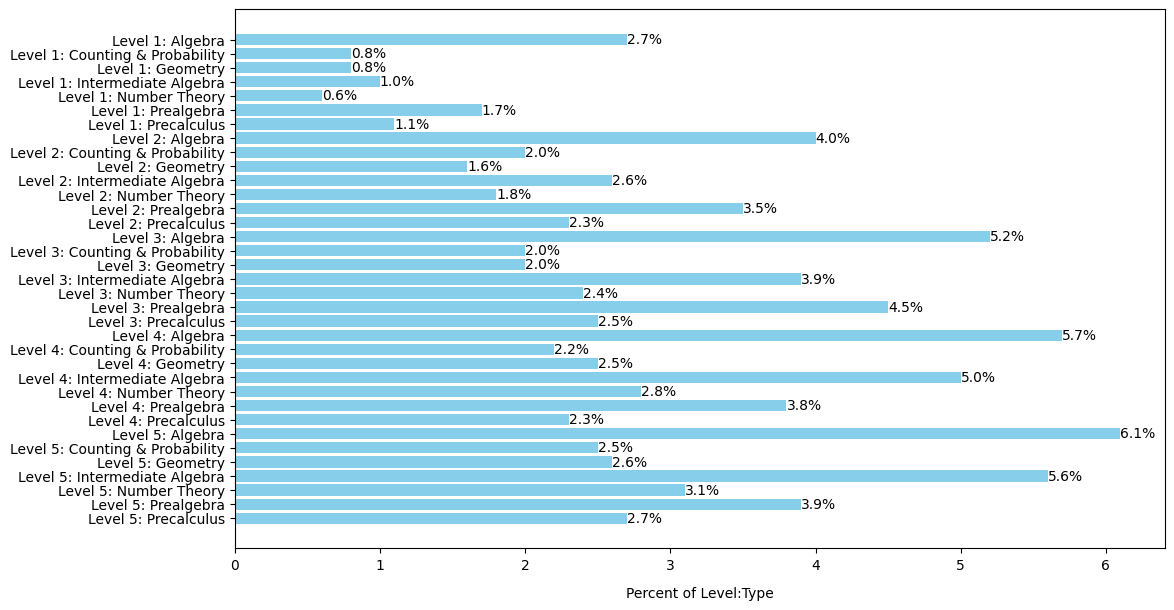

In [8]:
get_competition_math_level_type_distribution().show()

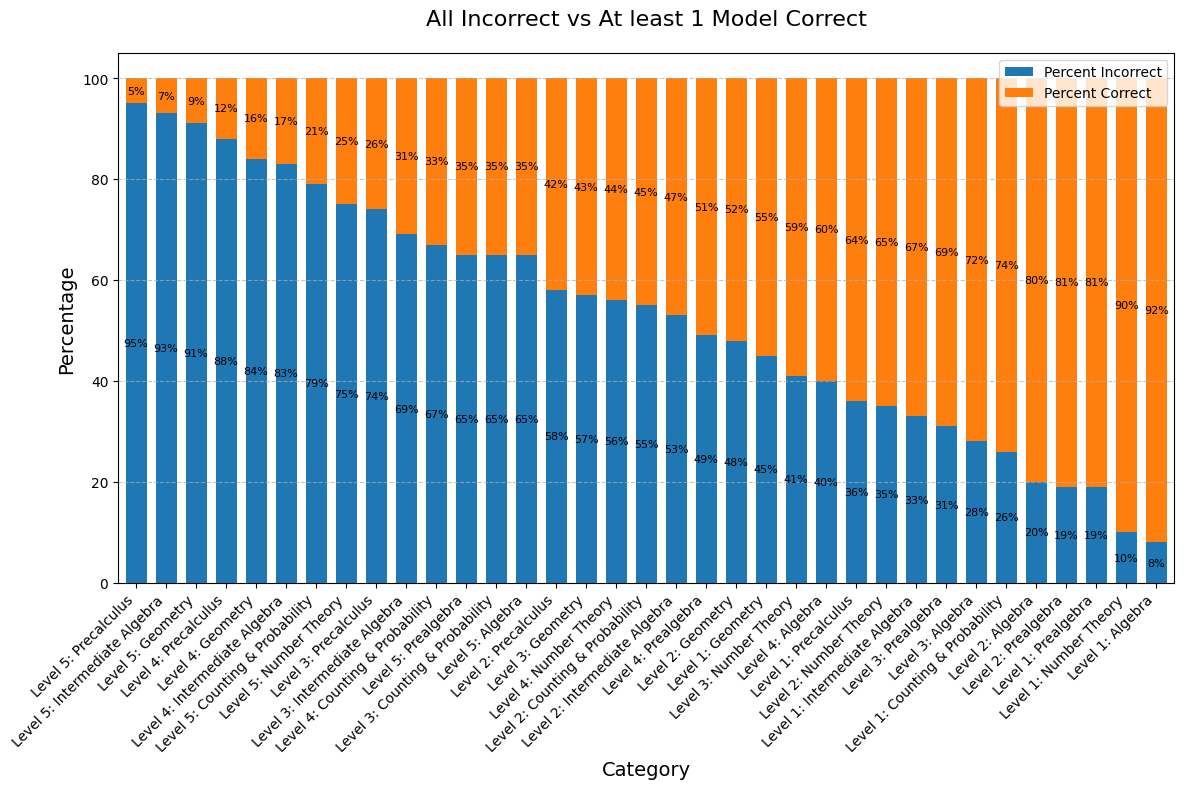

In [69]:
import matplotlib.pyplot as plt

df = get_competition_math_individual_breakdown_all_incorrect()

percent_incorrect = [float(p.strip('%')) for p in df["Total Incorrect"]]
percent_correct = [float(p.strip('%')) for p in df["Total Correct"]]
df["Percent Correct"] = percent_correct
df["Percent Incorrect"] = percent_incorrect
df = df[["Level:Type", "Percent Incorrect", "Percent Correct"]]

# Increase figure size and adjust spacing
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust width and height

# Plot stacked bar chart
df.plot.bar(x="Level:Type", stacked=True, ax=ax, width=0.7)  # Adjust width for spacing

# Rotate and align x-axis labels
plt.xticks(rotation=45, ha='right')

# Add bar labels for percentages
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%', label_type='center', size=8)

# Adjust title and axis labels for better readability
ax.set_title("All Incorrect vs At least 1 Model Correct", fontsize=16, pad=20)
ax.set_ylabel("Percentage", fontsize=14)
ax.set_xlabel("Category", fontsize=14)

# Add grid for clarity
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to fit everything
plt.tight_layout()

# Show plot
plt.show()



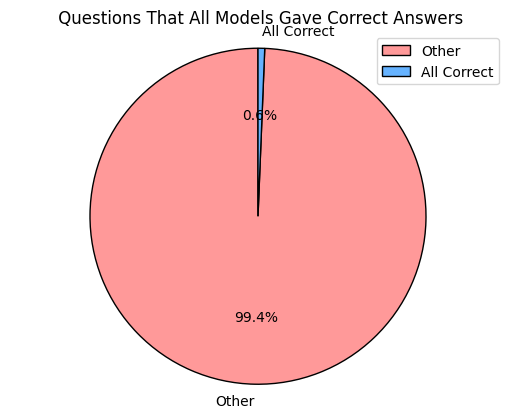

In [70]:
give_ensemble_model_all_correct_piechart().show()
#give_ensemble_model_all_incorrect_piechart().show()
#give_ensemble_model_all_agree_piechart().show()

#give_ensemble_model_atleast3_piechart().show()

In [98]:
get_competition_math_individual_breakdown_all_incorrect()

,Level:Type,Question #s Incorrect by All Models,Total Incorrect,Question #s Correct by at least 1 Model,Total Correct,Percent of Level:Type in Dataset
31,Level 5: Precalculus,"4458, 4462, 4470, 4473, 4483, 4485, 4486, 4490...",95%,"4455, 4465, 4673, 4919, 4925, 4959",5%,2.7
15,Level 5: Intermediate Algebra,"2140, 2146, 2149, 2155, 2158, 2169, 2171, 2177...",93%,"2167, 2224, 2226, 2280, 2309, 2416, 2440, 2490...",7%,5.6
11,Level 5: Geometry,"1663, 1665, 1666, 1667, 1669, 1671, 1676, 1677...",91%,"1705, 1713, 1748, 1754, 1759, 1766, 1779, 1996...",9%,2.6
30,Level 4: Precalculus,"4457, 4463, 4464, 4469, 4471, 4472, 4474, 4475...",88%,"4454, 4513, 4640, 4646, 4653, 4742, 4763, 4780...",12%,2.3
12,Level 4: Geometry,"1664, 1672, 1674, 1678, 1682, 1683, 1686, 1688...",84%,"1675, 1700, 1761, 1797, 1846, 1854, 1858, 1874...",16%,2.5
17,Level 4: Intermediate Algebra,"2142, 2144, 2151, 2152, 2165, 2170, 2174, 2179...",83%,"2194, 2205, 2241, 2307, 2350, 2380, 2435, 2438...",17%,5.0
8,Level 5: Counting & Probability,"1190, 1192, 1194, 1195, 1199, 1200, 1202, 1203...",79%,"1205, 1235, 1246, 1267, 1328, 1336, 1387, 1395...",21%,2.5
22,Level 5: Number Theory,"3046, 3047, 3050, 3061, 3062, 3064, 3067, 3078...",75%,"3056, 3070, 3071, 3075, 3090, 3105, 3116, 3130...",25%,3.1
33,Level 3: Precalculus,"4459, 4460, 4461, 4466, 4467, 4468, 4476, 4493...",74%,"4487, 4508, 4538, 4555, 4582, 4589, 4594, 4609...",26%,2.5
18,Level 3: Intermediate Algebra,"2145, 2147, 2148, 2150, 2163, 2166, 2175, 2178...",69%,"2143, 2154, 2162, 2164, 2176, 2190, 2216, 2220...",31%,3.9


In [111]:
all_results[all_results["row_index"] == 3043]

,row_index,level,type,llama3_is_correct,llama_solution,llema_is_correct,llema_solution,level:type,qwen_is_correct,qwen_solution,mistral_is_correct,mistral_solution,all_correct,all_incorrect,at_least_3_correct,at_least_2_correct,at_least_1_correct,all_agree
3043,3043,Level 2,Number Theory,False,1,False,None,Level 2: Number Theory,False,1,False,Error Parsing Response,False,True,False,False,False,False


In [110]:
print(list(test_dataset_df[test_dataset_df["row_index"] == 3043]["problem"])[0])

test_dataset_df[test_dataset_df["row_index"] == 3043]

A positive multiple of 45 less than 1000 is randomly selected. What is the probability that it is a two-digit integer? Express your answer as a common fraction.


,problem,level,type,solution,extracted_solution,row_index,Level:Type
3043,A positive multiple of 45 less than 1000 is ra...,Level 2,Number Theory,"The positive multiples of 45 are \[45,90,135,...",\frac{1}{11},3043,Level 2: Number Theory
